In [1]:
# temporary fix to unable to import modules in utils.py
import sys
sys.path.append('/home/amk/projects/pcb_defect_detection/src/with_annotation')

In [2]:
from src.with_annotation.dataset import PCBDataset
from src.with_annotation.model import CustomRCNN
import src.with_annotation.transforms as T
from src.with_annotation.utils import train_one_epoch, evaluate
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import src.with_annotation.utils_ as utils

root = '/home/amk/data/DeepPCB/PCBData'

In [3]:
def transforms(train):
    t = []
    t.append(T.PILToTensor())
    if train:
        # during training, flip the training images and
        # ground truth for data augmentation
        t.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(t)

In [4]:
batch_size = 5
target_acc = 0.995
lr = 0.0001
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device used: ' + str(device))
model = CustomRCNN()

model.to(device)

# Specity optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Device used: cuda


/home/amk/anaconda3/envs/pcb_detect/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amk/anaconda3/envs/pcb_detect/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model

CustomRCNN(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=0.5, std=0.5)
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d(256, eps=0.0)


In [6]:
from torch.utils.data import DataLoader

train_data = PCBDataset(root, 'trainval.txt', transforms=transforms(train=True))
test_data = PCBDataset(root, 'test.txt', transforms=transforms(train=False))

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)

In [7]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_dataloader, device=device)

IndexError: too many indices for tensor of dimension 0

In [18]:
model_path = '/home/amk/projects/pcb_defect_detection/weights/23.4.16_vgg16_640x640_7ep.h5'
torch.save(model, model_path)

Accuracy: 0.9860
Balanced Accuracy: 0.9860



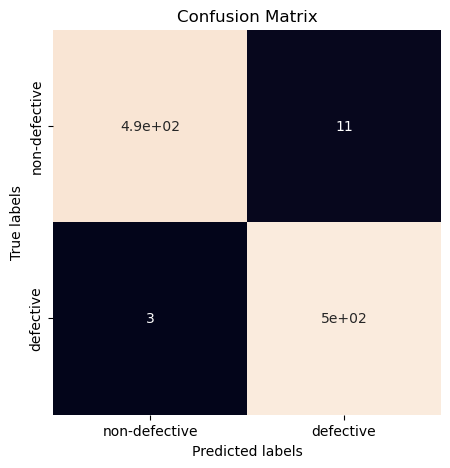

In [7]:
model_path = '/home/amk/projects/pcb_defect_detection/weights/23.4.16_vgg16_640x640_7ep.h5'
model = torch.load(model_path, map_location=device)
evaluate(model, test_dataloader, device)

/home/amk/anaconda3/envs/pcb_detect/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


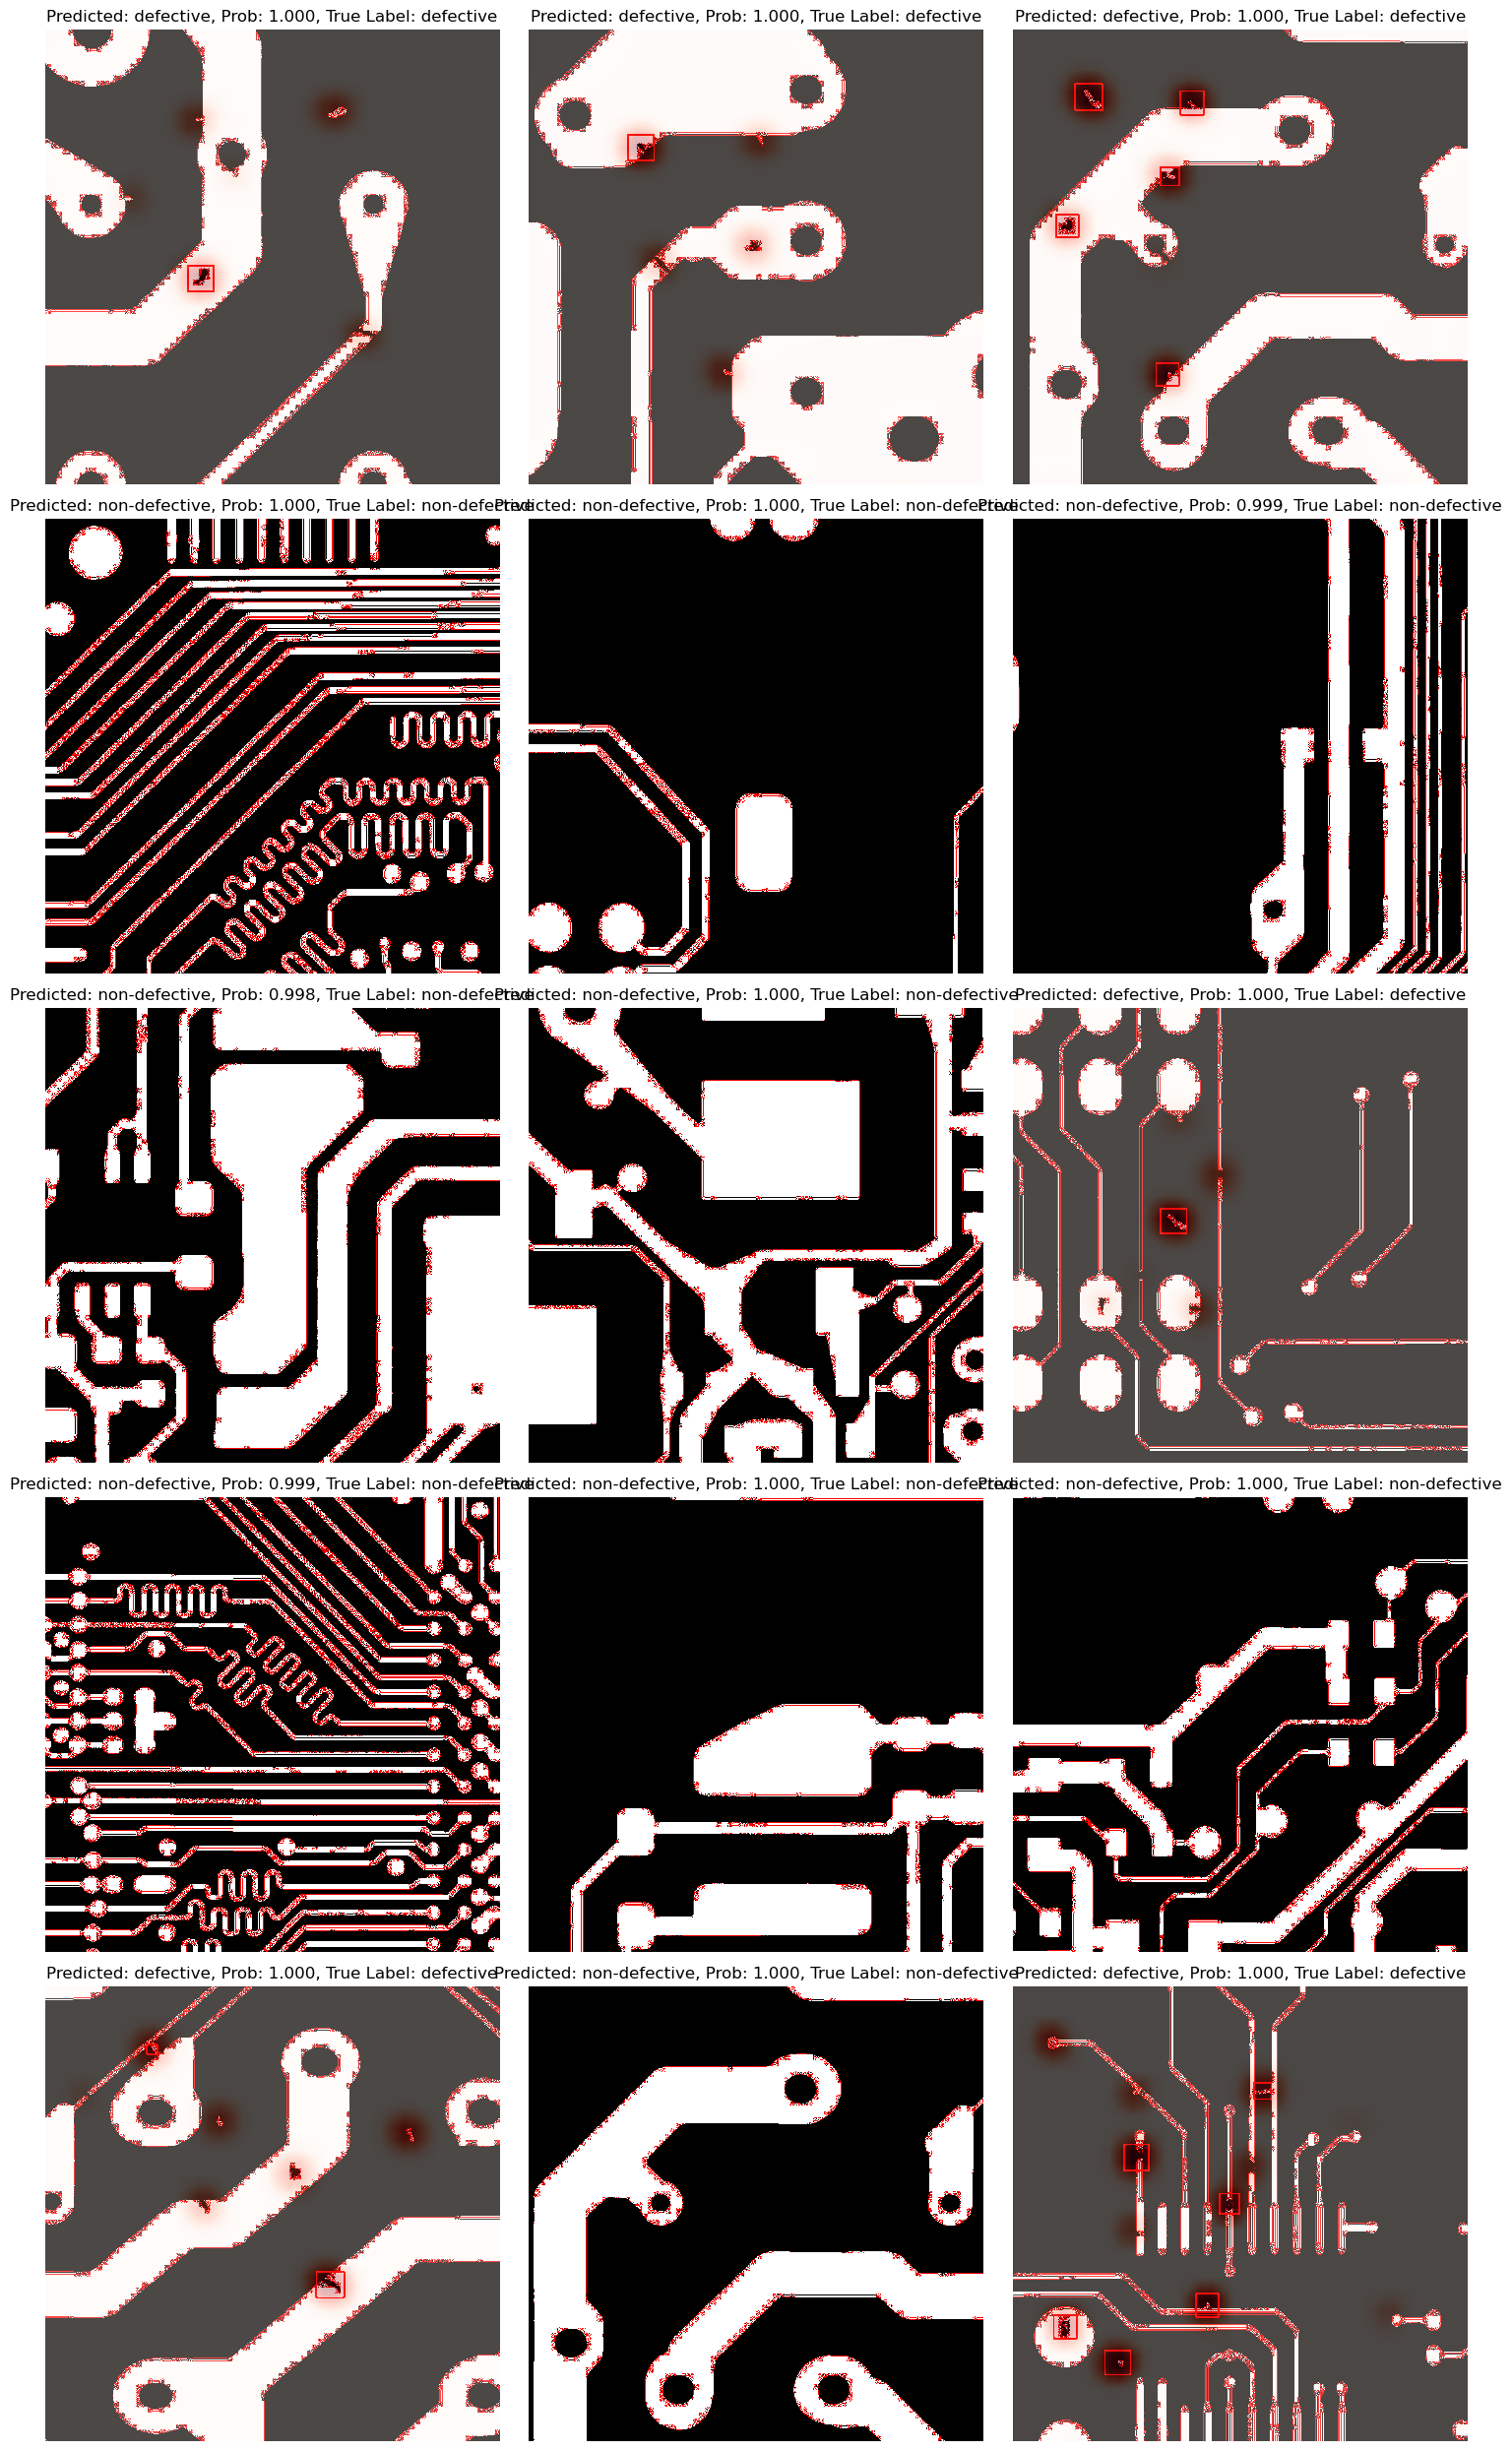

In [8]:
heatmap_thres = 0.7
predict_localize(
    model, test_dataloader, device, thres=heatmap_thres, n_samples=15, show_heatmap=True
)